# CBOW 


## Continious Bag of Words

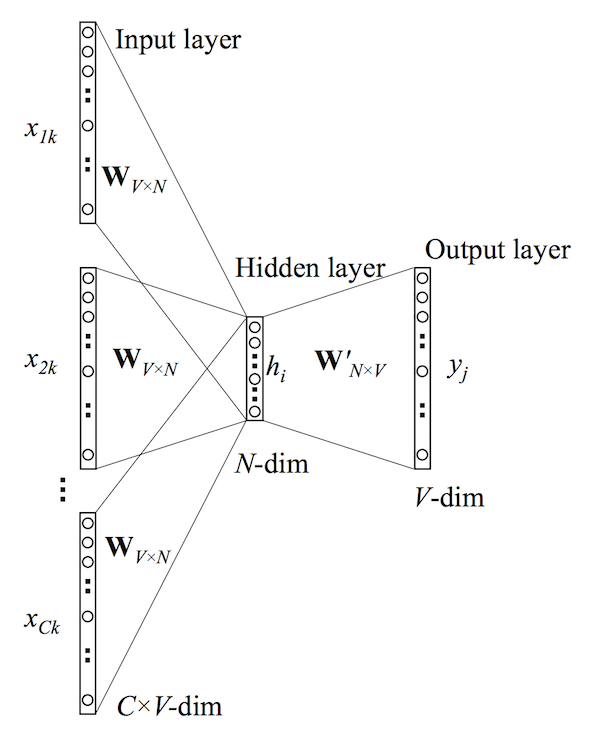

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import urllib.request
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances


In [41]:

torch.manual_seed(1)

CONTEXT_SIZE = 3
EMBEDDING_DIM = 10

test_sentence = """Mlx is great bedbugs are horrible I have bedbugs great this is a filler senetence Mlx is awesome""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)

def get_key(word_id):
    for key,val in word_to_ix.items():
        if(val == word_id):
            print(key)

def cluster_embeddings(filename,nclusters):
    X = np.load(filename)
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(X)
    center = kmeans.cluster_centers_
    distances = euclidean_distances(X,center)

    for i in np.arange(0,distances.shape[1]):
        word_id = np.argmin(distances[:,i])
        print(word_id)
        get_key(word_id)

def read_data(file_path):
    tokenizer = RegexpTokenizer(r'\w+')
    data = urllib.request.urlopen(file_path)
    data = data.read().decode('utf8')
    tokenized_data = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.',',',':',';','(',')','#','--','...','"'])
    cleaned_words = [ i for i in tokenized_data if i not in stop_words ]
    return(cleaned_words)

#test_sentence = read_data('https://www.gutenberg.org/files/57884/57884-0.txt')

ngrams = []
for i in range(len(test_sentence) - CONTEXT_SIZE):
    tup = [test_sentence[j] for j in np.arange(i , i + CONTEXT_SIZE) ]
    ngrams.append((tup,test_sentence[i + CONTEXT_SIZE]))
# print the first 3, just so you can see what they look like
#print(ngrams)


vocab = set(test_sentence)
print("Length of vocabulary",len(vocab))
word_to_ix = {word: i for i, word in enumerate(vocab)}


class CBOWModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))  # -1 implies size inferred for that index from the size of the data
        #print(np.mean(np.mean(self.linear2.weight.data.numpy())))
        out1 = F.relu(self.linear1(embeds)) # output of first layer
        out2 = self.linear2(out1)           # output of second layer
        #print(embeds)
        log_probs = F.log_softmax(out2, dim=1)
        return log_probs

    def predict(self,input):
        context_idxs = torch.tensor([word_to_ix[w] for w in input], dtype=torch.long)
        res = self.forward(context_idxs)
        res_arg = torch.argmax(res)
        res_val, res_ind = res.sort(descending=True)
        res_val = res_val[0][:3]
        res_ind = res_ind[0][:3]
        #print(res_val)
        #print(res_ind)
        for arg in zip(res_val,res_ind):
            #print(arg)
            print([(key,val,arg[0]) for key,val in word_to_ix.items() if val == arg[1]])

    def freeze_layer(self,layer):
        for name,child in model.named_children():
            print(name,child)
            if(name == layer):
                for names,params in child.named_parameters():
                    print(names,params)
                    print(params.size())
                    params.requires_grad= False

    def print_layer_parameters(self):
        for name,child in model.named_children():
                print(name,child)
                for names,params in child.named_parameters():
                    print(names,params)
                    print(params.size())

    def write_embedding_to_file(self,filename):
        for i in self.embeddings.parameters():
            weights = i.data.numpy()
        np.save(filename,weights)



losses = []
loss_function = nn.NLLLoss()
model = CBOWModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Freeze embedding layer
#model.freeze_layer('embeddings')


for epoch in range(400):
    total_loss = 0
    #------- Embedding layers are trained as well here ----#
    #lookup_tensor = torch.tensor([word_to_ix["poor"]], dtype=torch.long)
    #hello_embed = model.embeddings(lookup_tensor)
    #print(hello_embed)
    # -----------------------------------------------------#

    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        #print("Context id",context_idxs)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
        #print(log_probs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(loss)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)
#print(losses)  # The loss decreased every iteration over the training data!

#Print the model layer parameters
#model.print_layer_parameters()

#Predict the next word given n context words
# model.predict(['queen','is','a'])
model.write_embedding_to_file('embeddings.npy')
cluster_embeddings('embeddings.npy',2)

Length of vocabulary 13
38.91896963119507
38.6563880443573
38.395400047302246
38.135947704315186
37.87866759300232
37.623159885406494
37.36940622329712
37.11720156669617
36.86631631851196
36.616697788238525
36.368367195129395
36.12142610549927
35.87557649612427
35.63071537017822
35.38735342025757
35.145264863967896
34.90407109260559
34.663992524147034
34.42498159408569
34.1866352558136
33.9492324590683
33.71246552467346
33.47674226760864
33.24190664291382
33.00815963745117
32.77513539791107
32.542991042137146
32.31150782108307
32.080841422080994
31.850883841514587
31.621721982955933
31.393183827400208
31.16594111919403
30.939193844795227
30.71296536922455
30.487881064414978
30.26319980621338
30.03909182548523
29.816139698028564
29.593592405319214
29.371467113494873
29.150503516197205
28.930200457572937
28.71045231819153
28.49155080318451
28.27352261543274
28.056167006492615
27.83933734893799
27.623296976089478
27.40754759311676
27.192457795143127
26.977896451950073
26.764030694961548
2

C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Assuming word_to_ix is the dictionary that maps words to their corresponding indices

# 1. Load embeddings
embeddings = np.load('embeddings.npy')

# 2. Apply t-SNE for 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# 3. Get cluster assignments (assuming you've already used KMeans before)
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
clusters = kmeans.predict(embeddings)

# 4. 2D Plot
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.7)

# Create a colorbar legend
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Cluster ID')

# Adding labels. For clarity, we'll add labels for a subset of points. 
# You can modify this to add more labels or label specific points of interest.
num_labels = 5  # Change this value as needed
ix_to_word = {ix:word for word, ix in word_to_ix.items()}
indices = np.random.choice(len(embeddings), num_labels, replace=False)  # Random subset of indices

for i in indices:
    ax.text(embeddings_tsne[i, 0], embeddings_tsne[i, 1], ix_to_word[i], size=10, zorder=1, color='k')

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_title('2D t-SNE visualization of Embeddings with Labels')
plt.show()

ValueError: perplexity must be less than n_samples

# Purple Cluster: Represents a group of words that are more similar to each other than they are to the words in the yellow cluster.

# Yellow Cluster: Represents another distinct group of words.

In [56]:
model.predict(['Mlx','bedbugs','is'])

[('a', 10, tensor(-1.6699, grad_fn=<UnbindBackward0>))]
[('bedbugs', 1, tensor(-1.6833, grad_fn=<UnbindBackward0>))]
[('is', 5, tensor(-1.9625, grad_fn=<UnbindBackward0>))]


In [37]:
model.predict(['ya','da','dahil'])

[('olmak', 20, tensor(-0.0690, grad_fn=<UnbindBackward0>))]
[('olursa', 22, tensor(-4.1094, grad_fn=<UnbindBackward0>))]
[('kuruldu', 8, tensor(-4.6172, grad_fn=<UnbindBackward0>))]


In [39]:
model.predict(['olmak','isteyen','olursa'])

[('community', 4, tensor(-0.0894, grad_fn=<UnbindBackward0>))]
[('da', 14, tensor(-4.1415, grad_fn=<UnbindBackward0>))]
[("community'si", 27, tensor(-4.6782, grad_fn=<UnbindBackward0>))]


In [28]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Assuming word_to_ix is the dictionary that maps words to their corresponding indices

# 1. Load embeddings
embeddings = np.load('embeddings.npy')

# 2. Apply t-SNE for 3 dimensions
tsne = TSNE(n_components=3, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# 3. Get cluster assignments (assuming you've already used KMeans before)
kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)
clusters = kmeans.predict(embeddings)

# 4. Create a DataFrame for Plotly
import pandas as pd
df = pd.DataFrame(embeddings_tsne, columns=["Component 1", "Component 2", "Component 3"])
df['Cluster'] = clusters
df['Label'] = [ix_to_word[i] for i in range(len(embeddings))]

# 5. 3D Interactive Plot
fig = px.scatter_3d(df, x='Component 1', y='Component 2', z='Component 3',
                    color='Cluster', text='Label',
                    opacity=0.7, color_continuous_scale='viridis')

# This will allow you to hover over points and see the labels as tooltips.
# For better performance, you might choose to display a subset of labels instead of all.
fig.update_traces(textposition='top center', selector=dict(mode='markers+text'))

fig.show()


ValueError: perplexity must be less than n_samples

C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ikaan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

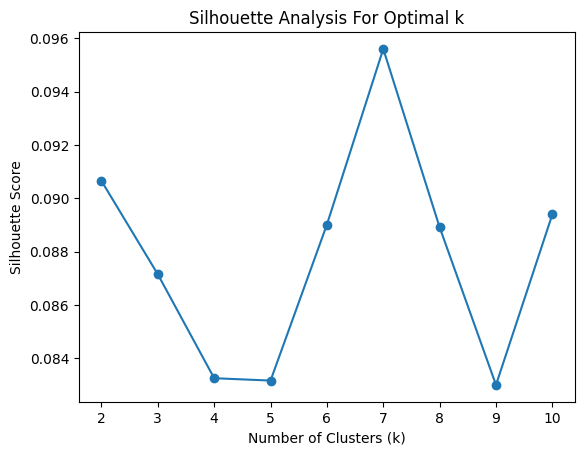

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []

# Start from 2 clusters, as silhouette score requires more than 1 cluster.
K_range_sil = range(2, 11)

for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    cluster_assignments = kmeans.predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_assignments)
    sil_scores.append(silhouette_avg)

plt.plot(K_range_sil, sil_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()